In [1]:
import numpy as np
import pandas as pd
import coupled_LDS
import scipy.stats as stats
import scipy.linalg
from utils import *
import matplotlib.pyplot as plt
from plotting_utils import *
import autograd.numpy as anp 
import os
from sippy_unipi import *
from sklearn.linear_model import LinearRegression
import scipy.linalg as sl
from coupled_LDS import *
from EI_subspace_RNN import * 
import seaborn
seaborn.set_context("talk")

K1 = 2 
K2 = 5

# Generate EI RNN

In [2]:
U = 100
T = 100
K = K1 + K2
D = 200
M = 2
N_e = int(D / 2) # number of units in the RNN
N_i = int(D / 2)
N = N_e + N_i
sparsity = 0.25     
N_weights = int (N * N * sparsity)

LDS = coupled_LDS(D, K1, K2, M)    
# generate known inputs 
u = LDS.generate_inputs(U,T)

J1 = np.random.normal(0, 1/np.sqrt(N), (N,N))
J, _ = np.linalg.qr(J1)  # QR decomposition, Q is the orthogonal matrix
J = J[:K1,:]
J_inv = np.linalg.pinv(J) # pseudo-inverse (J * J_inv = identity, but J_inv * J is not)
print(J.shape)
        

(2, 200)


In [3]:
RNN = EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
zeta_alpha_beta_gamma_list = [(10**i,1,1,10**(i-2)) for i in list(np.arange(-1,0.5,1))]

LDS1 = coupled_LDS(D, K1, 0, M)  
eigvals1 = generate_eigenvalues(K1, R=1) # in disc of radius R = 1
A11 = LDS1.generate_dynamics_matrix(eigvals1, np.array([]), disconnected=False)
print(A11)

# fit = np.load(f'models/K1={K1}_K2={K2}_true_parameters_EI-RNN.npz')
# A11=fit['A']
# initW = fit['W']
# v=fit['v']
initW0, initW, loss_W, w_all = RNN.generate_or_initialize_weights_from_dynamics_LDS(A_target=A11, R=0.85, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)

[[ 0.31398519  0.37134812]
 [-0.37134812  0.31398519]]
0
10
20
30
40
(0.1, 1, 1, 0.001)
(1.0, 1, 1, 0.01)


(0.0, 1.0)

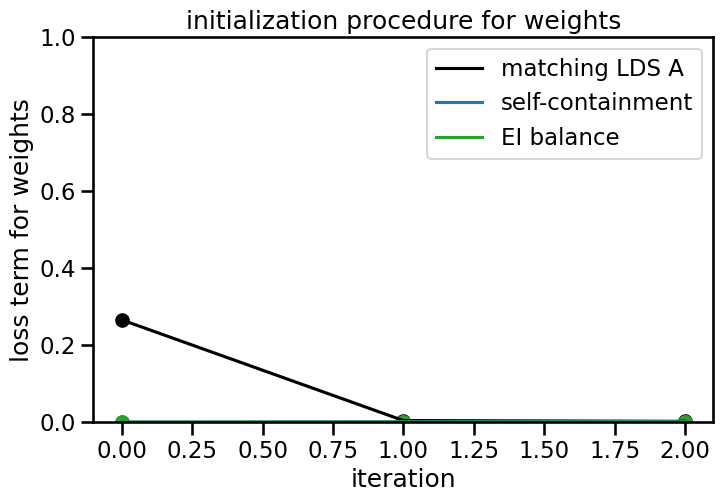

In [4]:
fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,0], color='black', label='matching LDS A')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,0], color='black')
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,1], color='tab:blue')
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,2], color='tab:green', label='EI balance')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,2], color='tab:green')
axes.legend()
axes.set_title('initialization procedure for weights')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')
axes.set_ylim(0,1)

In [5]:
# J_perp = np.eye(N) - J_inv @ J
J_perp = scipy.linalg.null_space(J).T # null space is orthogonal complement to row(J)
print(J_perp.shape)
J_full = np.concatenate((J,J_perp), axis=0)

Uh, S, Vh = np.linalg.svd(J_full)
print(S)


(198, 200)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


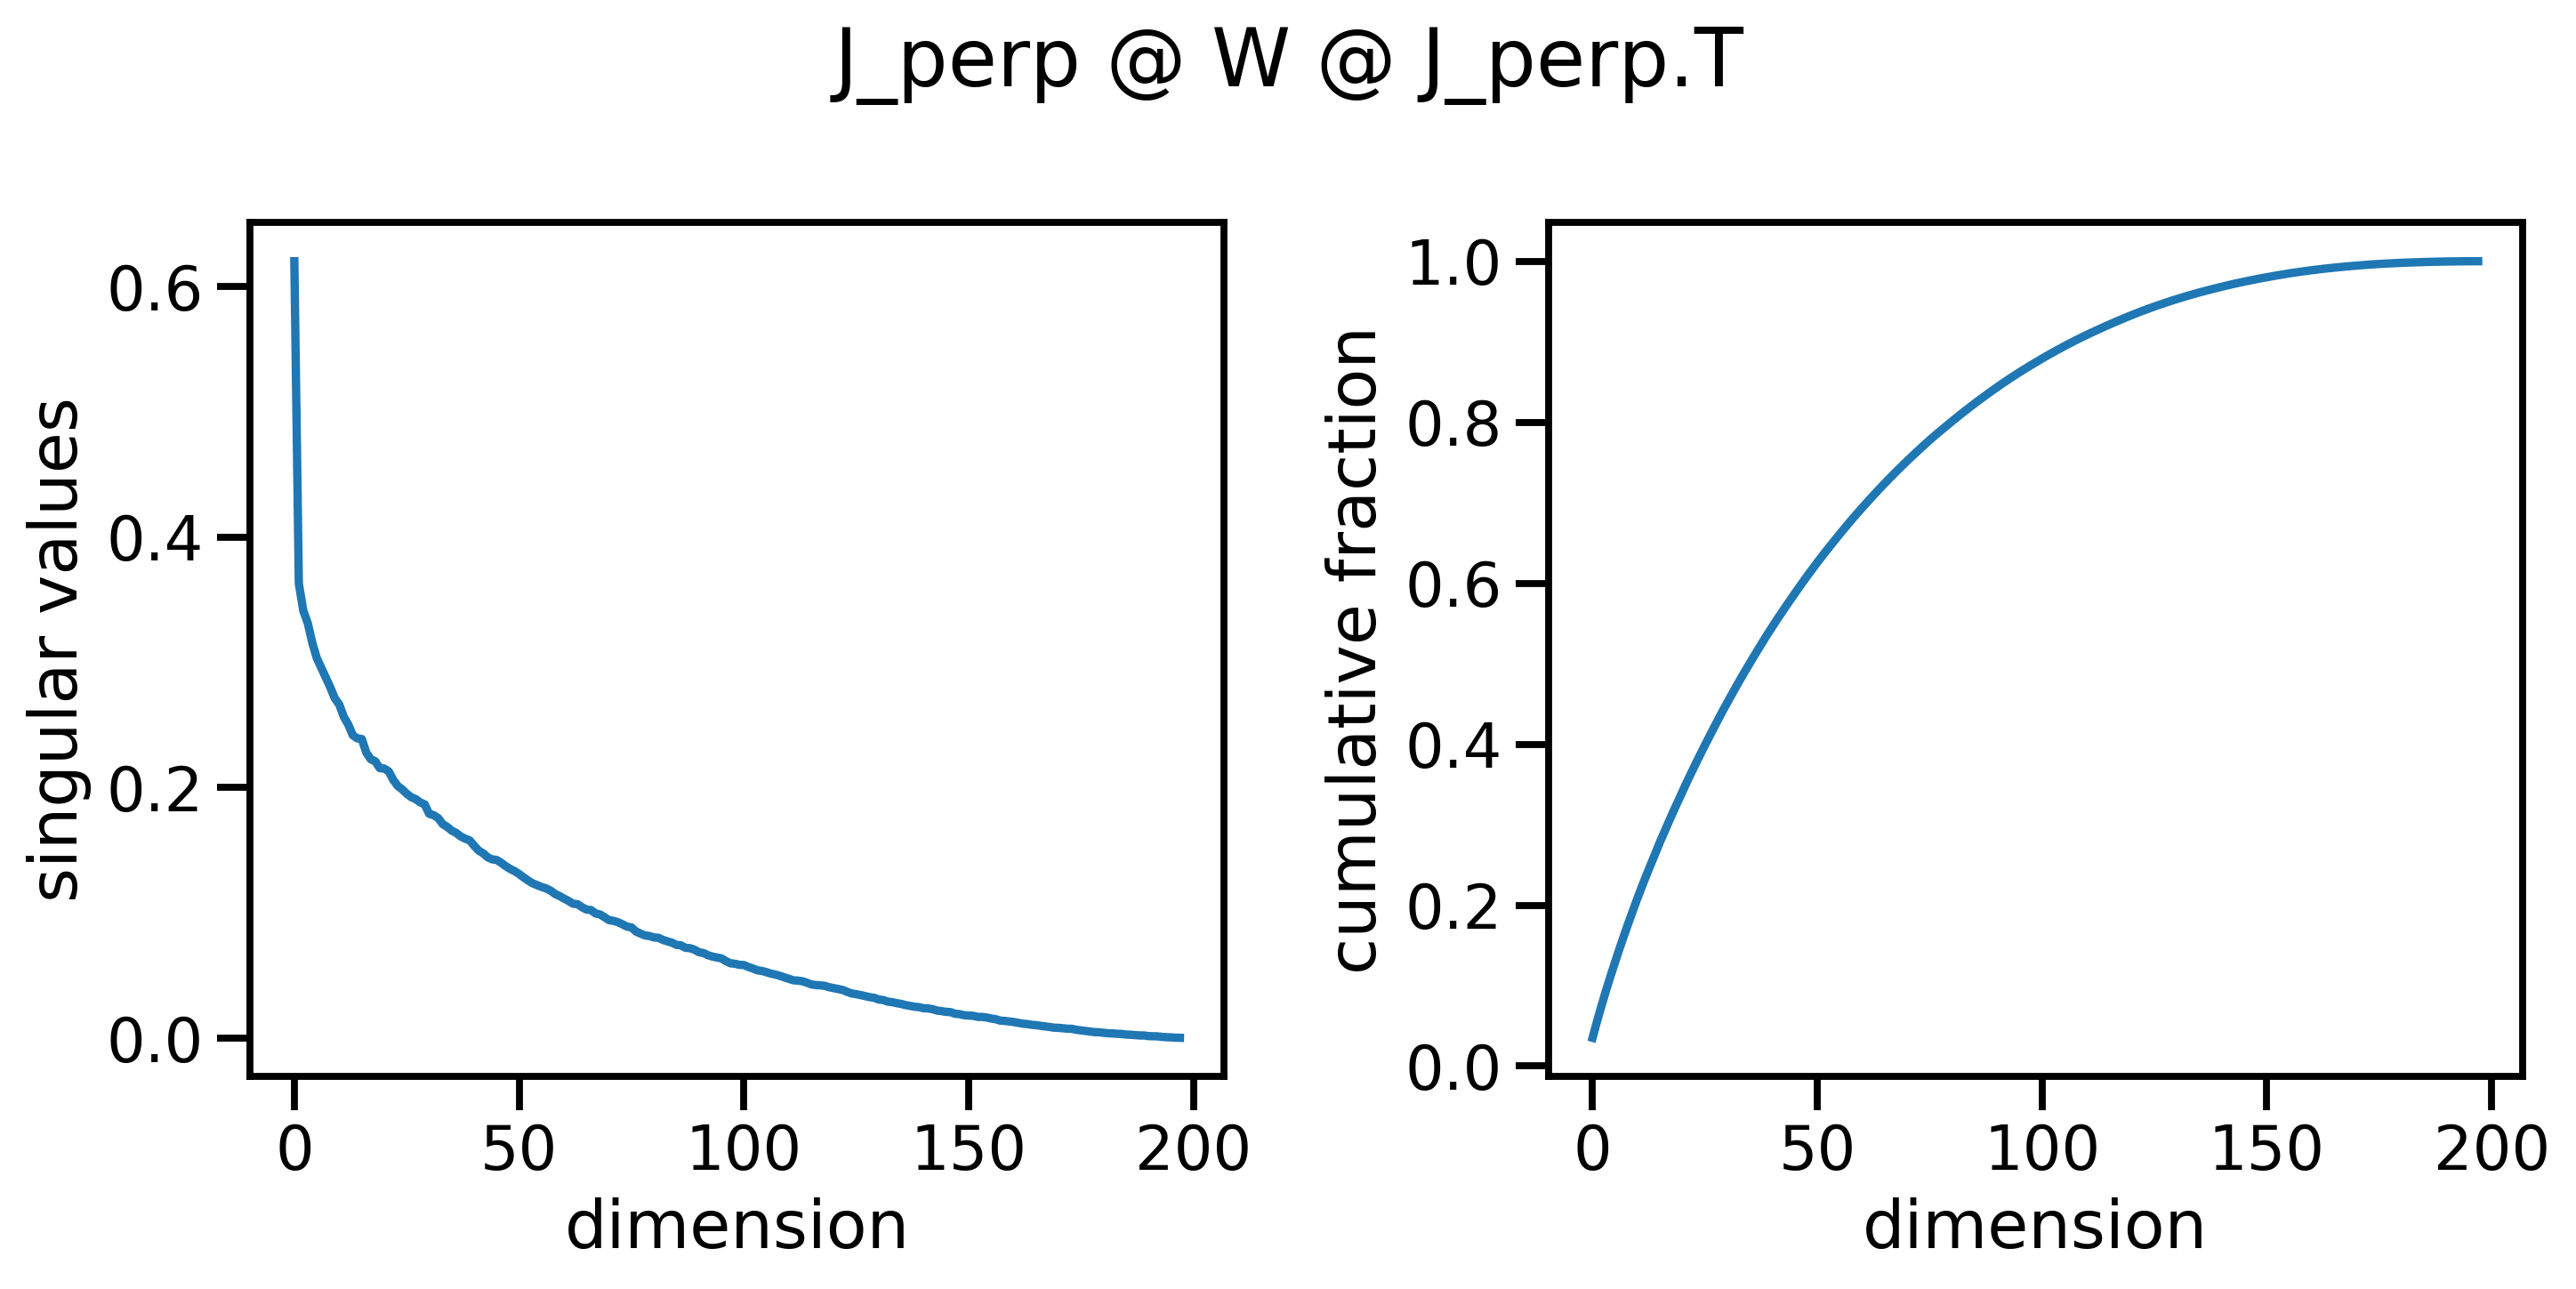

In [6]:
# Do PCA to see how much variance exists in J_perp W J_perp ^ T

W22 = J_perp @ initW @ J_perp.T
Uh, S, Vh = np.linalg.svd(W22)

frac_cumul = np.zeros((S.shape[0]))
for i in range(S.shape[0]):
    frac_cumul[i] = np.sum(S[:i+1])
frac_cumul = frac_cumul / np.sum(S)

fig, axes = plt.subplots(1,2,figsize=(10,5),dpi=300)
axes[0].plot(S)
axes[0].set_ylabel('singular values')
fig.suptitle('J_perp @ W @ J_perp.T')
axes[1].set_ylabel('cumulative fraction')
axes[0].set_xlabel('dimension')
axes[1].set_xlabel('dimension')
axes[1].plot(frac_cumul)
fig.tight_layout()


In [7]:
# generate network activity
b, s, mu0, Q0, C_, d, R = RNN.generate_parameters(D, K1)
v = RNN.generate_network_activity(U, T, initW, b, s, mu0, Q0)

(198, 198)


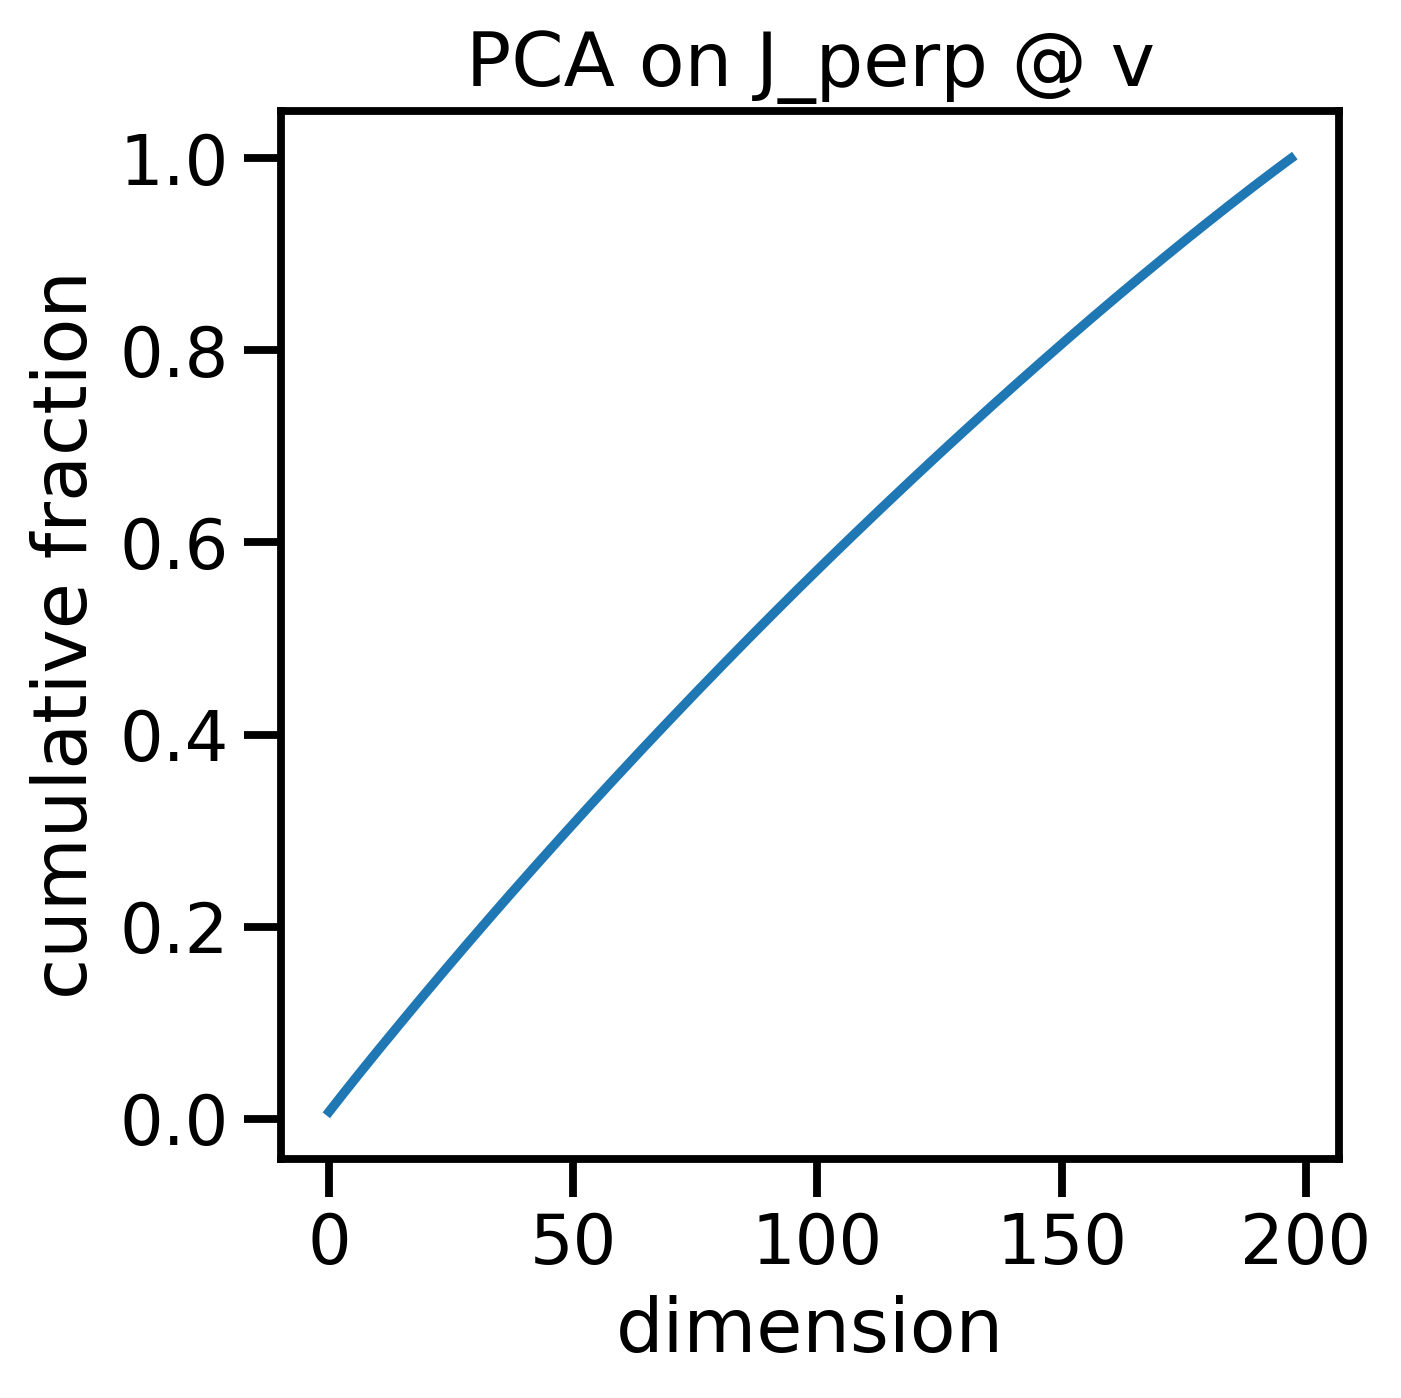

In [8]:
# project network activity in J_perp and do PCA
v_concat = v.reshape(v.shape[0]*v.shape[1],v.shape[2])

v_perp = v_concat @ J_perp.T
cov_perp = v_perp.T @ v_perp
Uh, S, Vh = np.linalg.svd(cov_perp)
print(cov_perp.shape)
frac_cumul = np.zeros((cov_perp.shape[0]))
for i in range(cov_perp.shape[0]):
    frac_cumul[i] = np.sum(S[:i+1])
frac_cumul = frac_cumul / np.sum(S)

fig, axes = plt.subplots(dpi=300,figsize=(5,5))
axes.plot(frac_cumul)
axes.set_ylabel('cumulative fraction')
axes.set_xlabel('dimension')
axes.set_title('PCA on J_perp @ v')
fig.tight_layout()

(200, 200)
(200, 2)
(200, 1)
3
(200, 2)
(200, 2)
4
(200, 2)
(200, 3)
5
(200, 2)
(200, 4)
6
(200, 2)
(200, 5)
7
(200, 2)
(200, 6)
8
(200, 2)
(200, 7)
9
(200, 2)
(200, 8)
10
(200, 2)
(200, 9)
11
(200, 2)
(200, 10)
12
(200, 2)
(200, 11)
13
(200, 2)
(200, 12)
14
(200, 2)
(200, 13)
15
(200, 2)
(200, 14)
16
(200, 2)
(200, 15)
17
(200, 2)
(200, 16)
18
(200, 2)
(200, 17)
19
(200, 2)
(200, 18)
20
(200, 2)
(200, 19)
21
(200, 2)
(200, 20)
22
(200, 2)
(200, 21)
23
(200, 2)
(200, 22)
24
(200, 2)
(200, 23)
25
(200, 2)
(200, 24)
26
(200, 2)
(200, 25)
27
(200, 2)
(200, 26)
28
(200, 2)
(200, 27)
29
(200, 2)
(200, 28)
30
(200, 2)
(200, 29)
31
(200, 2)
(200, 30)
32
(200, 2)
(200, 31)
33
(200, 2)
(200, 32)
34
(200, 2)
(200, 33)
35
(200, 2)
(200, 34)
36
(200, 2)
(200, 35)
37
(200, 2)
(200, 36)
38
(200, 2)
(200, 37)
39
(200, 2)
(200, 38)
40
(200, 2)
(200, 39)
41
(200, 2)
(200, 40)
42
(200, 2)
(200, 41)
43
(200, 2)
(200, 42)
44
(200, 2)
(200, 43)
45
(200, 2)
(200, 44)
46
(200, 2)
(200, 45)
47
(200, 2)
(200, 

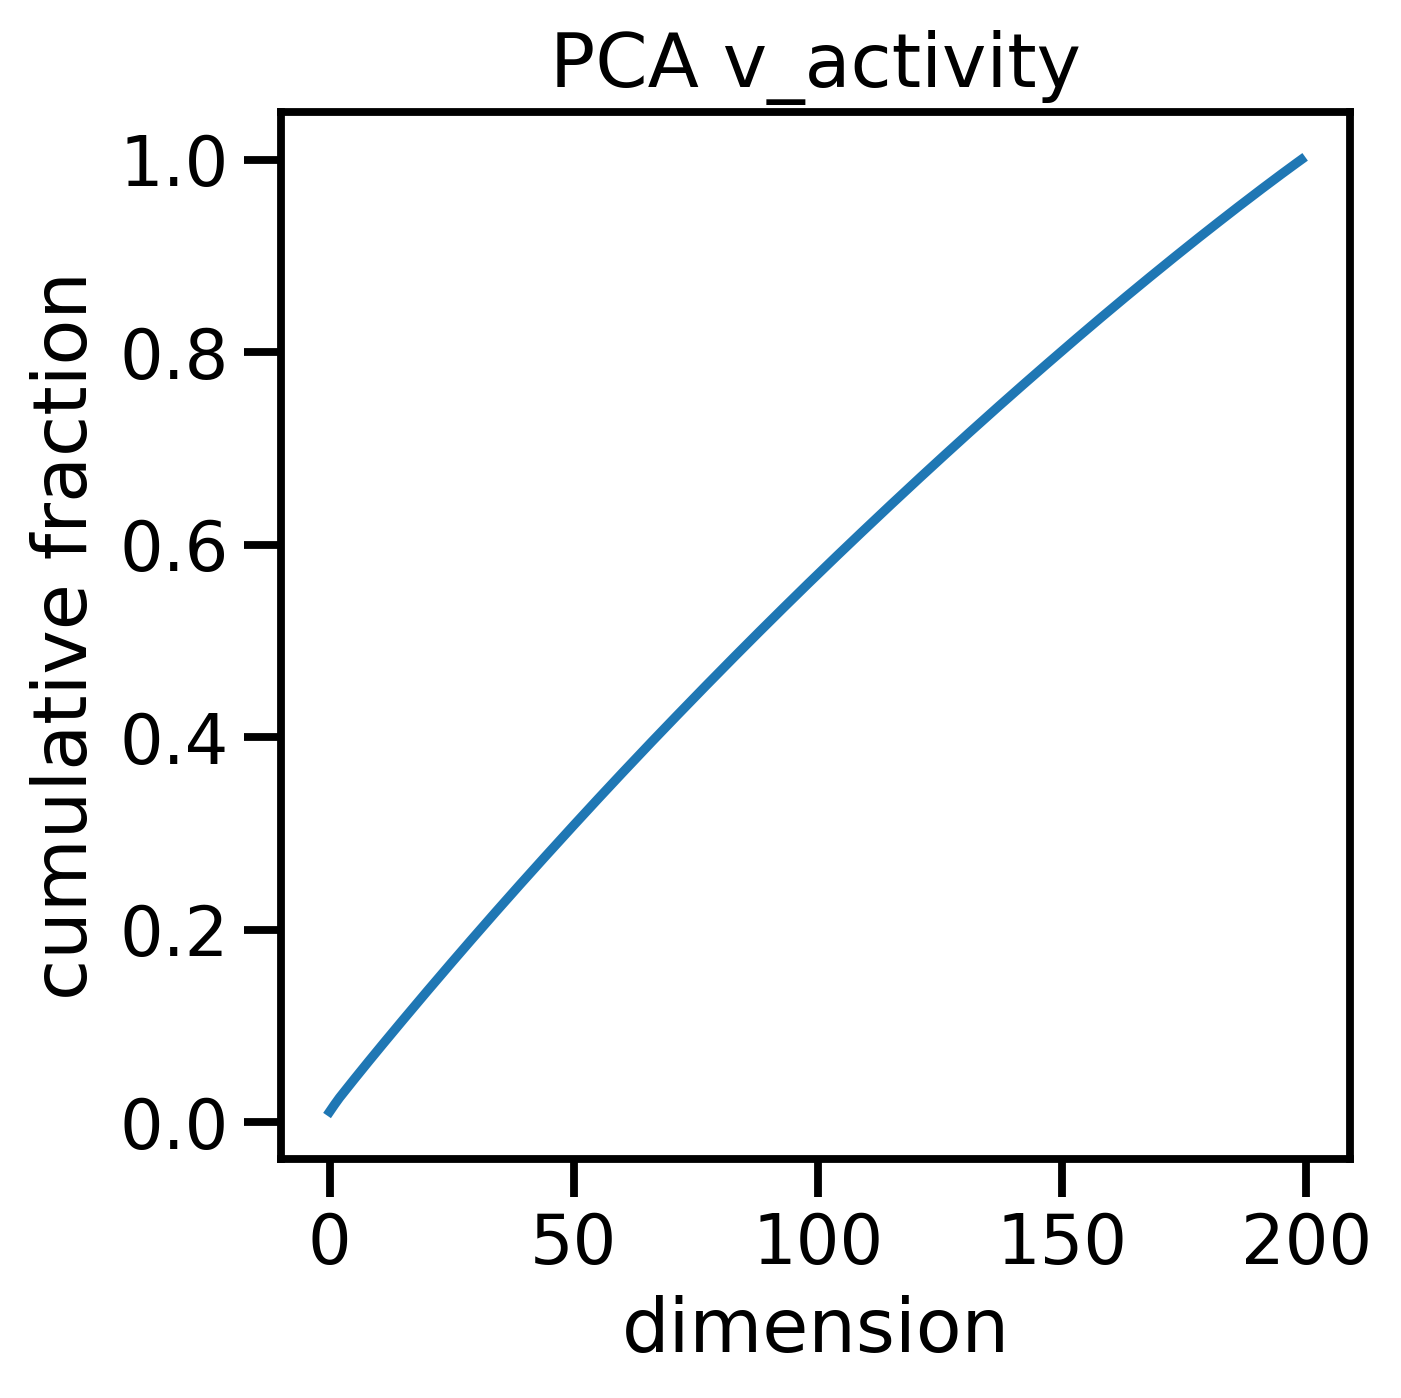

In [9]:
# do PCA on network activity and see how many dimensions you need in order to fully include J space
v_concat = v.reshape(v.shape[0]*v.shape[1],v.shape[2])

cov = v_concat.T @ v_concat
Uh, S, Vh = np.linalg.svd(cov)
print(cov.shape)
frac_cumul = np.zeros((cov.shape[0]))
for i in range(cov.shape[0]):
    frac_cumul[i] = np.sum(S[:i+1])
frac_cumul = frac_cumul / np.sum(S)



for i in range(1,D+1):
    print(J.T.shape)
    print(Uh[:,:i].shape)
    print(np.linalg.matrix_rank(np.concatenate([Uh[:,:i],J.T], axis=1)))

fig, axes = plt.subplots(dpi=300,figsize=(5,5))
axes.plot(frac_cumul)
axes.set_ylabel('cumulative fraction')
axes.set_xlabel('dimension')
axes.set_title('PCA v_activity')
fig.tight_layout()

In [ ]:
b, s, mu0, Q0, C_, d, R = RNN.generate_parameters(D,K1)
true_x, true_y = RNN.generate_latents_and_observations(U, T, A11, b, s, mu0, Q0, C_, d, R)

In [30]:
# saving 

np.savez(f'models/K1={K1}_K2={K2}_true_parameters_EI-RNN', A=A11, W=initW, v=v)
